In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
anomaly_types = pd.read_csv('/content/anomaly_types_cleaned.csv')
channels = pd.read_csv('/content/channels_cleaned.csv')
events = pd.read_csv('/content/events_cleaned.csv')
labels = pd.read_csv('/content/labels_cleaned.csv')
telecommands = pd.read_csv('/content/telecommands_cleaned.csv')

In [7]:
#timestamp to datetime
labels['StartTime'] = pd.to_datetime(labels['StartTime'], format='mixed')
labels['EndTime'] = pd.to_datetime(labels['EndTime'], format='mixed')
labels['StartTime'] = labels['StartTime'].dt.tz_localize(None)
labels['EndTime'] = labels['EndTime'].dt.tz_localize(None)

In [8]:
#time series data
np.random.seed(42)
time_index = pd.date_range(start='2004-12-01', end='2004-12-10', freq='T')  # 1-min intervals
channels_list = channels['Channel'].unique()
data = {ch: np.sin(np.linspace(0, 50, len(time_index))) + np.random.normal(0, 0.2, len(time_index)) for ch in channels_list}
df = pd.DataFrame(data, index=time_index)

/tmp/ipython-input-8-1395564694.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index = pd.date_range(start='2004-12-01', end='2004-12-10', freq='T')  # 1-min intervals


In [9]:
#anomaly injection
for _, row in labels.iterrows():
    ch = row['Channel']
    start = pd.to_datetime(row['StartTime'])
    end = pd.to_datetime(row['EndTime'])
    if ch in df.columns:
        df.loc[start:end, ch] += np.random.normal(5, 1, len(df.loc[start:end]))

In [10]:
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [12]:
#making sequences
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

In [13]:
channel = channels_list[0]
X_seq, _ = create_sequences(scaled_df[channel].values.reshape(-1, 1), window_size=30)

In [14]:
#training
def is_anomaly(timestamps, label_df):
    for _, row in label_df.iterrows():
        if row['Channel'] == channel:
            if ((timestamps >= row['StartTime']) & (timestamps <= row['EndTime'])).any():
                return True
    return False

mask = np.array([not is_anomaly(scaled_df.index[i:i+30], labels) for i in range(len(X_seq))])
X_train = X_seq[mask]

In [15]:
#autoencoder of LSTM
input_dim = X_train.shape[2]
timesteps = X_train.shape[1]

inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(64, activation='relu', return_sequences=False)(inputs)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(input_dim))(decoded)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=20, batch_size=64, validation_split=0.1, callbacks=[EarlyStopping(patience=3)])

Epoch 1/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - loss: 0.0616 - val_loss: 0.0036
Epoch 2/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 3/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 4/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 5/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 6/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 7/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 8/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 9/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.0034 - val_loss: 0.0034


In [16]:
#Predict and calculate anomaly scores
X_pred = autoencoder.predict(X_seq)
mse = np.mean(np.power(X_seq - X_pred, 2), axis=(1,2))

threshold = np.percentile(mse, 95)
binary_preds = (mse > threshold).astype(int)

405/405 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step


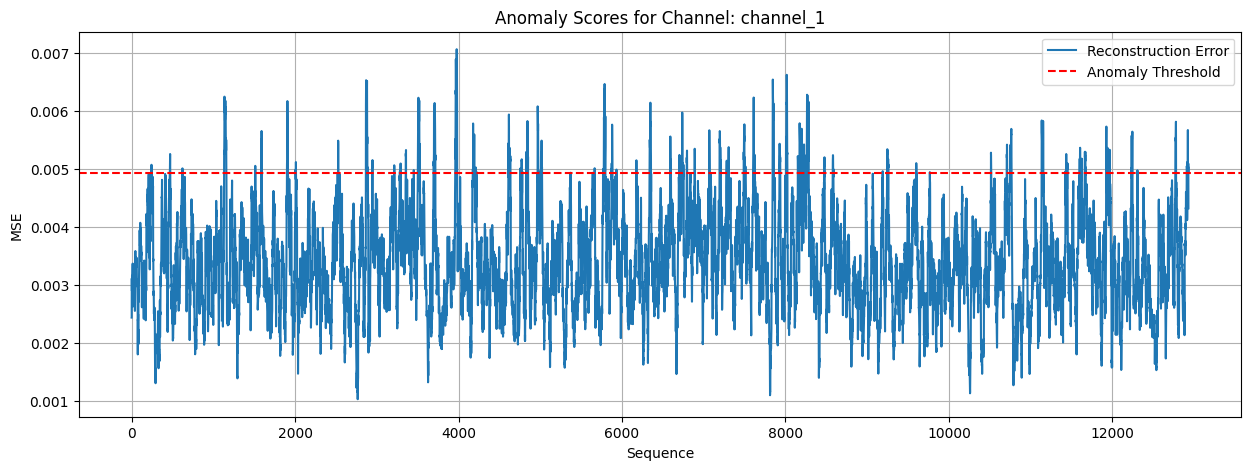

In [17]:
plt.figure(figsize=(15,5))
plt.plot(mse, label='Reconstruction Error')
plt.axhline(threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.title(f"Anomaly Scores for Channel: {channel}")
plt.xlabel("Sequence")
plt.ylabel("MSE")
plt.legend()
plt.grid()
plt.show()

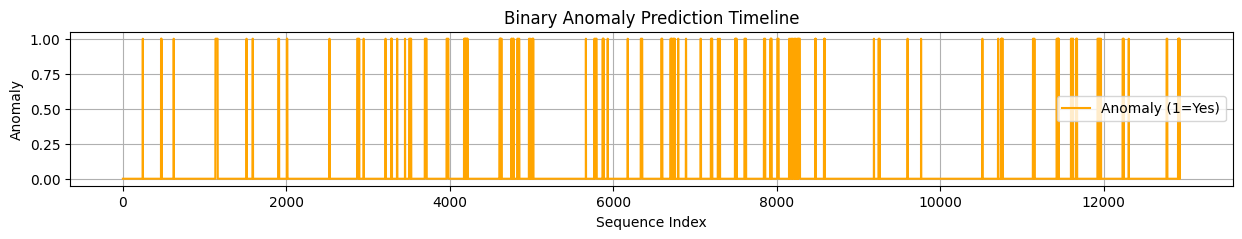

In [18]:
#binary prediction timeline
plt.figure(figsize=(15,2))
plt.plot(binary_preds, label='Anomaly (1=Yes)', color='orange')
plt.title("Binary Anomaly Prediction Timeline")
plt.xlabel("Sequence Index")
plt.ylabel("Anomaly")
plt.grid()
plt.legend()
plt.show()